# **Phát hiện biển số xe và dự đoán kí tự trên biển số xe**

## Phần 1: Phát hiện biển số xe.

### **1.1. Notebook này đào tạo mô hình với dataset gốc.**

---

# **Topic: Detecting license plates and predicting characters on license plates**

## Part 1: Detecting license plates.

### **1.1. In this notebook, we train the model with the original dataset.**

## **Import thư viện**

In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import zipfile


## 1. Tải ảnh và annotation vào dưới dạng tensors).

In [2]:
xml_folder = '/kaggle/input/dataset/licenseplates/annotations'
img_folder = '/kaggle/input/dataset/licenseplates/images'
def parse_annotations(xml_folder, img_folder, input_size):
    images = []
    bboxes = []

    for xml_file in os.listdir(xml_folder):
        if xml_file.endswith(".xml"):
            # Load XML file
            tree = ET.parse(os.path.join(xml_folder, xml_file))
            root = tree.getroot()
            
            # Load image
            file_name = root.find("filename").text
            img_path = os.path.join(img_folder, file_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (input_size, input_size))
            img = img / 255.0  # Normalize
            images.append(img)

            # Load bounding box
            obj = root.find("object")
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Scale bounding box to [0, 1]
            width = int(root.find("size/width").text)
            height = int(root.find("size/height").text)
            bboxes.append([
                xmin / width, ymin / height,
                xmax / width, ymax / height
            ])

    return np.array(images), np.array(bboxes)

# Đường dẫn tới thư mục ảnh và XML
# xml_folder = "path/to/xml/folder"
# img_folder = "path/to/image/folder"

# Chuẩn bị dữ liệu
input_size = 224
images, bboxes = parse_annotations(xml_folder, img_folder, input_size)

print("Shape of images:", images.shape)
print("Shape of bounding boxes:", bboxes.shape)


Shape of images: (6903, 224, 224, 3)
Shape of bounding boxes: (6903, 4)


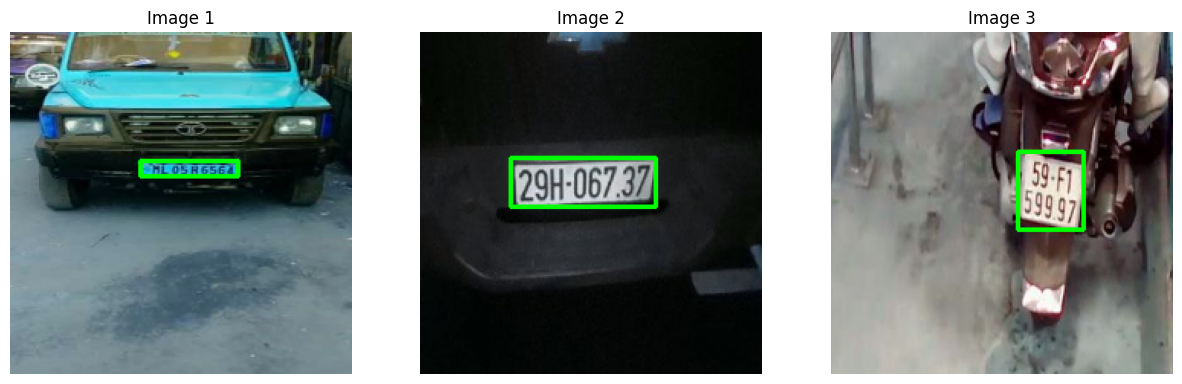

In [3]:
# Hàm vẽ bounding box lên ảnh
def draw_bboxes(images, bboxes):
    plt.figure(figsize=(15, 5))

    for i in range(3):  # Vẽ 3 hình ảnh đầu tiên
        img = images[i].copy()  # Copy ảnh gốc để tránh thay đổi ảnh gốc
        bbox = bboxes[i]

        # Chuyển bounding box về dạng pixel (không phải tỷ lệ)
        height, width, _ = img.shape
        xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)

        # Vẽ bounding box
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Hiển thị ảnh
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.show()

# Vẽ 3 hình ảnh đầu tiên với bounding boxes
draw_bboxes(images, bboxes)


## 2. Xây dựng Mô hình CNN

Một mô hình CNN gồm các lớp tích chập (convolutional layers) để trích xuất đặc trưng, và các lớp fully connected để dự đoán tọa độ bounding box (xmin, ymin, xmax, ymax).

In [4]:
def build_custom_cnn(input_size):
    inputs = Input(shape=(input_size, input_size, 3))

    # Block 1
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation="relu")(x)

    # Output Layer: 4 neurons for (xmin, ymin, xmax, ymax)
    outputs = Dense(4, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

# Xây dựng mô hình
model = build_custom_cnn(input_size)
model.compile(optimizer="adam", loss="mse", metrics=["mae", "accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,817,028 (98.48 MB)

 Trainable params: 25,817,028 (98.48 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Chia dữ liệu thành train/test và huấn luyện mô hình

In [5]:
# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


I0000 00:00:1733075905.212372      97 service.cc:145] XLA service 0x7f0fcc00d980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733075905.212455      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4009 - loss: 0.0886 - mae: 0.2438

I0000 00:00:1733075910.897857      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.6318 - loss: 0.0301 - mae: 0.1275 - val_accuracy: 0.8262 - val_loss: 0.0113 - val_mae: 0.0735
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8144 - loss: 0.0114 - mae: 0.0762 - val_accuracy: 0.8899 - val_loss: 0.0072 - val_mae: 0.0553
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8675 - loss: 0.0077 - mae: 0.0618 - val_accuracy: 0.8979 - val_loss: 0.0072 - val_mae: 0.0570
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8742 - loss: 0.0061 - mae: 0.0556 - val_accuracy: 0.9015 - val_loss: 0.0053 - val_mae: 0.0451
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8899 - loss: 0.0044 - mae: 0.0482 - val_accuracy: 0.9232 - val_loss: 0.0051 - val_mae: 0.0457
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9134 - loss: 0.0037 - mae: 0.0443 - val_accuracy: 0.9167 - val_loss: 0.0046 - val_mae: 0.0421
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 3

## 4. Đánh giá mô hình bằng biểu đồ hàm accuraccy , mae và hàm loss

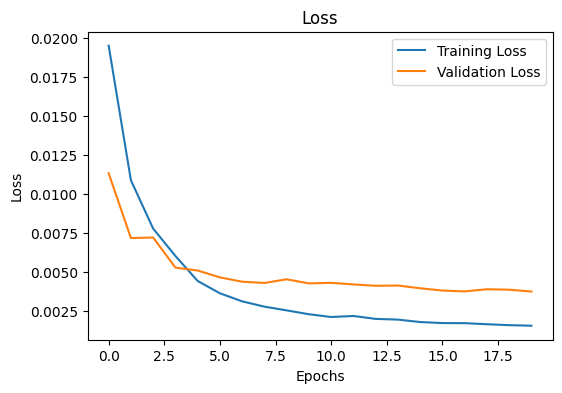

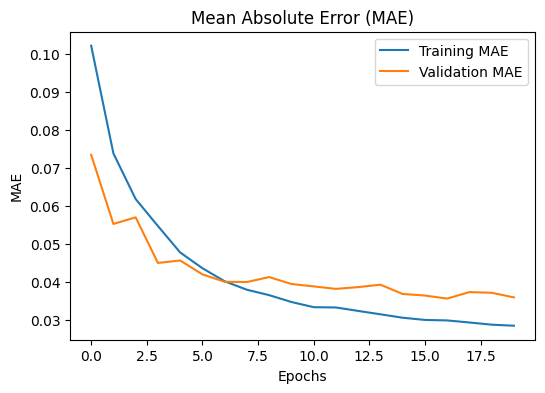

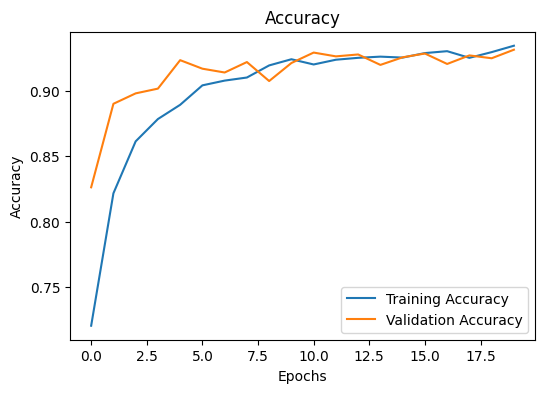

In [6]:

# Lấy dữ liệu lịch sử huấn luyện
history_dict = history.history

# Vẽ đồ thị Loss
plt.figure(figsize=(6, 4))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vẽ đồ thị MAE
plt.figure(figsize=(6, 4))
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Vẽ đồ thị Accuracy (nếu có)
if 'accuracy' in history_dict:
    plt.figure(figsize=(6, 4))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## 5. Hàm trực quan hóa visualize prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


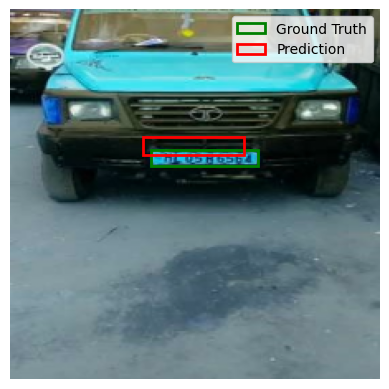

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


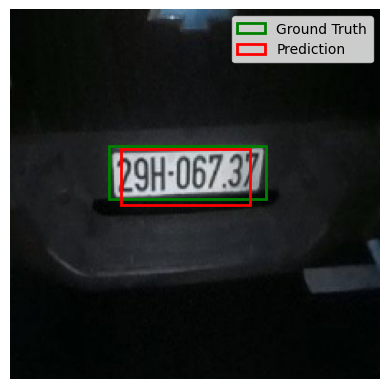

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


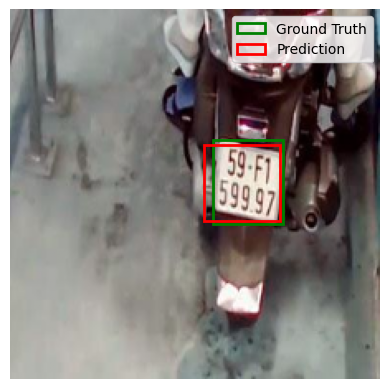

In [7]:
def visualize_prediction(image, bbox_true, bbox_pred):
    h, w, _ = image.shape
    plt.imshow(image)

    # Ground truth
    plt.gca().add_patch(plt.Rectangle(
        (bbox_true[0] * w, bbox_true[1] * h),  # xmin, ymin
        (bbox_true[2] - bbox_true[0]) * w,    # width
        (bbox_true[3] - bbox_true[1]) * h,    # height
        fill=False, edgecolor="green", linewidth=2, label="Ground Truth"
    ))

    # Prediction
    plt.gca().add_patch(plt.Rectangle(
        (bbox_pred[0] * w, bbox_pred[1] * h),  # xmin, ymin
        (bbox_pred[2] - bbox_pred[0]) * w,    # width
        (bbox_pred[3] - bbox_pred[1]) * h,    # height
        fill=False, edgecolor="red", linewidth=2, label="Prediction"
    ))
    plt.legend()
    plt.axis('off')
    plt.show()

# Vẽ 3 ảnh dự đoán
for i in range(3):
    sample_image = images[i]  # Chọn ảnh thứ i
    sample_bbox_true = bboxes[i]  # Ground truth bounding box
    # Giả sử bạn đã có mô hình dự đoán
    sample_bbox_pred = model.predict(np.expand_dims(sample_image, axis=0))[0]  # Dự đoán từ mô hình

    visualize_prediction(sample_image, sample_bbox_true, sample_bbox_pred)


## 6. Lưu mô hình

In [8]:
model.save('/kaggle/working/license_plate_model.h5')
print("Model saved successfully!")

Model saved successfully!


# Test dự đoán

## 7. Hàm dự đoán bounding box của biển số xe

In [11]:
def predict_bounding_box(image, model, original_size):
    """
    Dự đoán bounding box trên một ảnh duy nhất.
    
    Args:
        image (numpy.ndarray): Ảnh đã được chuẩn hóa và thay đổi kích thước.
        model (keras.Model): Mô hình CNN đã được huấn luyện.
        original_size (tuple): Kích thước gốc của ảnh (height, width).
    
    Returns:
        tuple: Bounding box dự đoán (xmin, ymin, xmax, ymax).
    """
    original_height, original_width = original_size
    
    # Dự đoán bounding box
    pred_bbox = model.predict(np.expand_dims(image, axis=0))[0]  # Output: [xmin, ymin, xmax, ymax]
    
    # Chuyển bounding box về kích thước gốc của ảnh
    xmin = int(pred_bbox[0] * original_width)
    ymin = int(pred_bbox[1] * original_height)
    xmax = int(pred_bbox[2] * original_width)
    ymax = int(pred_bbox[3] * original_height)
    
    return (xmin, ymin, xmax, ymax)

## 8. Hàm hiển thị hình ảnh đã dự đoán bounding box

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dự đoán bounding box: (592, 363, 869, 422)


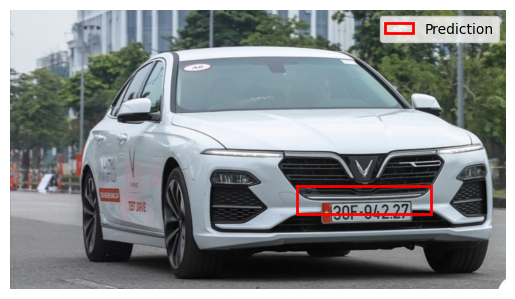

In [19]:
def preprocess_image(image_path, input_size):
    """
    Đọc và chuẩn bị ảnh đầu vào cho mô hình.
    
    Args:
        image_path (str): Đường dẫn tới ảnh.
        input_size (int): Kích thước đầu vào của mô hình.
    
    Returns:
        numpy.ndarray: Ảnh đã được chuẩn hóa và resize.
        tuple: Kích thước gốc của ảnh (height, width).
    """
    image = cv2.imread(image_path)
    original_size = image.shape[:2]  # Lưu kích thước gốc (height, width)
    image_resized = cv2.resize(image, (input_size, input_size))
    image_normalized = image_resized / 255.0  # Chuẩn hóa về [0, 1]
    return image_normalized, original_size

def visualize_prediction(image_path, bbox):
    """
    Hiển thị ảnh cùng với bounding box dự đoán.
    
    Args:
        image_path (str): Đường dẫn tới ảnh gốc.
        bbox (tuple): Bounding box (xmin, ymin, xmax, ymax).
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image_rgb)
    plt.gca().add_patch(plt.Rectangle(
        (bbox[0], bbox[1]),                # xmin, ymin
        bbox[2] - bbox[0],                 # width
        bbox[3] - bbox[1],                 # height
        fill=False, edgecolor="red", linewidth=2, label="Prediction"
    ))
    plt.legend()
    plt.axis("off")
    plt.show()

# Đường dẫn tới ảnh và mô hình
image_path = "/kaggle/input/testdataa11/testdataa/test2.jpeg"

# Tiền xử lý ảnh
input_size = 224
image_preprocessed, original_size = preprocess_image(image_path, input_size)

# Dự đoán bounding box
pred_bbox = predict_bounding_box(image_preprocessed, model, original_size)

# In kết quả dự đoán
print(f"Dự đoán bounding box: {pred_bbox}")

# Hiển thị ảnh với bounding box
visualize_prediction(image_path, pred_bbox)


# Tăng cường dữ liệu
## 9. Chia lại tập train test với inputsize = 200 

In [5]:
input_size = 200
images, bboxes = parse_annotations(xml_folder, img_folder, input_size)
# Chia dữ liệu thành train/test
X_train, X_test, y_train, y_test = train_test_split(images, bboxes, test_size=0.2, random_state=42)

In [6]:
print(X_train.shape)
print(y_train.shape)

(5522, 200, 200, 3)
(5522, 4)


## 10. Thực hiện tăng cường bằng phương pháp lật ảnh theo chiều ngang

In [7]:
# Hàm lật ảnh và điều chỉnh bounding box
def horizontal_flip(image, box):
    # Lật ảnh theo chiều ngang
    flipped_image = np.fliplr(image)

    # Điều chỉnh bounding box (từ tỷ lệ sang pixel -> lật -> chuyển lại về tỷ lệ)
    input_width = image.shape[1]
    xmin, ymin, xmax, ymax = box * input_width
    flipped_box = np.array([
        input_width - xmax, ymin, 
        input_width - xmin, ymax
    ]) / input_width

    return flipped_image, flipped_box

# Tăng cường dữ liệu
X_train_augmented = []
y_train_augmented = []

for i in range(len(X_train)):
    image = X_train[i]
    box = y_train[i]

    # Lật ảnh và điều chỉnh bounding box
    flipped_image, flipped_box = horizontal_flip(image, box)

    # Thêm ảnh gốc và ảnh lật vào dữ liệu tăng cường
    X_train_augmented.append(image)
    y_train_augmented.append(box)
    X_train_augmented.append(flipped_image)
    y_train_augmented.append(flipped_box)

# Chuyển đổi sang numpy arrays
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Kết quả
print("Shape of original X_train:", X_train.shape)
print("Shape of original y_train:", y_train.shape)
print("Shape of augmented X_train:", X_train_augmented.shape)
print("Shape of augmented y_train:", y_train_augmented.shape)


Shape of original X_train: (5522, 200, 200, 3)
Shape of original y_train: (5522, 4)
Shape of augmented X_train: (11044, 200, 200, 3)
Shape of augmented y_train: (11044, 4)


## 11. Lưu các tập dữ liệu train test đã tăng cường 

In [8]:
# Lưu X_train và y_train vào thư mục làm việc
np.save('/kaggle/working/X_train.npy', X_train_augmented)  # Lưu dữ liệu X_train
np.save('/kaggle/working/y_train.npy', y_train_augmented)  # Lưu dữ liệu y_train


# Đường dẫn tệp cần nén
file_path = '/kaggle/working/X_train.npy'
zip_file_path = '/kaggle/working/X_train.zip'

# Nén tệp
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_path, arcname='X_train.npy')  # Tạo tệp zip chứa X_train.npy

print(f"Tệp đã được nén và lưu tại {zip_file_path}")


Tệp đã được nén và lưu tại /kaggle/working/X_train.zip


In [9]:
# Lưu X_train và y_train vào thư mục làm việc
np.save('/kaggle/working/X_test.npy', X_test)  # Lưu dữ liệu X_train
np.save('/kaggle/working/y_test.npy', y_test)  # Lưu dữ liệu y_train